In [1144]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show columns with long strings
pd.set_option('display.max_colwidth', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [1145]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-05-21.csv'

print(today_date_str)

_2024-05-29.csv


In [1146]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

481 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number
0,NVDA,NVIDIA Corporation,Semiconductors,Electronic Technology,NASDAQ,"S&P 500, NASDAQ 100, NASDAQ Composite, PHLX Semiconductor Sector, S&P 500 Information Technology, S&P 100, Russell 3000, NASDAQ-100 Technology Sector, Russell 1000, NASDAQ Computer, S&P 500 ESG",2.847525e+12,USD,1139.01,USD,1150.30,USD,17.8800,USD,1.569784,0.991212,2.394405e+09,65270250,65272789,629997,45115057.4,4.484547e+07,5.025436e+07,7.708199,3.365021,3.073497,1129.076667,66.624357,1.516732,2.186068,2.430273,1.748256,2.824843,1.975780,1.715060,1.469993,0.758058,0.404707,0.894151,1.573352,0.291582,0.793934,1149.3900,USD,1149.39,USD,1149.39,USD,1149.39,USD,1149.39,USD,1141.3400,USD,1141.34,USD,1144.47,USD,1144.47,USD,1144.47,USD,1149.390,USD,1149.39,USD,1149.39,USD,1149.3900,USD,2.058176e+06,USD,1137.37700,1136.737075,1136.61310,1137.671300,1141.761878,1136.127790,1130.493702,1145.044411,1134.901795,1124.759179,US67066G1040
1,JNJ,Johnson & Johnson,Pharmaceuticals: Major,Health Technology,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Health Care, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, NYSE Arca Major Market",3.474764e+11,USD,144.38,USD,144.75,USD,0.4300,USD,0.297825,0.256268,2.402781e+09,10499829,10499829,867,7578012.8,8.137499e+06,7.569657e+06,1.956154,1.838196,1.394703,145.106733,20.796243,1.844753,0.513998,0.385069,0.546610,6.928034,6.527122,4.226269,3.192542,1.518792,0.982495,1.455685,1.480752,0.282730,0.578354,154.8600,USD,163.11,USD,163.58,USD,175.97,USD,186.69,USD,144.5600,USD,144.56,USD,144.56,USD,144.56,USD,144.56,USD,144.585,USD,146.79,USD,146.79,USD,154.8600,USD,6.455800e+05,USD,144.40100,144.365625,144.35100,144.346538,144.443800,144.344800,144.245800,144.454777,144.345005,144.235233,US4781601046
2,CVX,Chevron Corporation,Integrated Oil,Energy Minerals,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Energy, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, S&P 500 ESG, NYSE Arca Major Market",2.931053e+11,USD,159.04,USD,159.20,USD,0.3278,USD,0.206112,0.100604,1.842413e+09,6928298,6928298,857,58516

In [1147]:
#### CREATE MARKET CAP CATEGORIES ####
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans - 200 billion and above
        (df['Market capitalization'] >= 200000000000),
        # Large Cap - 10 billion to 200 billion
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),
        # Midlers - 2 billion to 10 billion
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),
        # Small Cap - 300 million to 2 billion
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000), 
        # Micro Cap - 50 million to 300 million
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),
        # Shrimp - 50 million and below
        (df['Market capitalization'] <= 50000000)
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df

In [1148]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,marketCapType
0,NVDA,NVIDIA Corporation,Semiconductors,Electronic Technology,NASDAQ,"S&P 500, NASDAQ 100, NASDAQ Composite, PHLX Semiconductor Sector, S&P 500 Information Technology, S&P 100, Russell 3000, NASDAQ-100 Technology Sector, Russell 1000, NASDAQ Computer, S&P 500 ESG",2.847525e+12,USD,1139.01,USD,1150.30,USD,17.8800,USD,1.569784,0.991212,2.394405e+09,65270250,65272789,629997,45115057.4,4.484547e+07,5.025436e+07,7.708199,3.365021,3.073497,1129.076667,66.624357,1.516732,2.186068,2.430273,1.748256,2.824843,1.975780,1.715060,1.469993,0.758058,0.404707,0.894151,1.573352,0.291582,0.793934,1149.3900,USD,1149.39,USD,1149.39,USD,1149.39,USD,1149.39,USD,1141.3400,USD,1141.34,USD,1144.47,USD,1144.47,USD,1144.47,USD,1149.390,USD,1149.39,USD,1149.39,USD,1149.3900,USD,2.058176e+06,USD,1137.37700,1136.737075,1136.61310,1137.671300,1141.761878,1136.127790,1130.493702,1145.044411,1134.901795,1124.759179,US67066G1040,Titans
1,JNJ,Johnson & Johnson,Pharmaceuticals: Major,Health Technology,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Health Care, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, NYSE Arca Major Market",3.474764e+11,USD,144.38,USD,144.75,USD,0.4300,USD,0.297825,0.256268,2.402781e+09,10499829,10499829,867,7578012.8,8.137499e+06,7.569657e+06,1.956154,1.838196,1.394703,145.106733,20.796243,1.844753,0.513998,0.385069,0.546610,6.928034,6.527122,4.226269,3.192542,1.518792,0.982495,1.455685,1.480752,0.282730,0.578354,154.8600,USD,163.11,USD,163.58,USD,175.97,USD,186.69,USD,144.5600,USD,144.56,USD,144.56,USD,144.56,USD,144.56,USD,144.585,USD,146.79,USD,146.79,USD,154.8600,USD,6.455800e+05,USD,144.40100,144.365625,144.35100,144.346538,144.443800,144.344800,144.245800,144.454777,144.345005,144.235233,US4781601046,Titans
2,CVX,Chevron Corporation,Integrated Oil,Energy Minerals,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Energy, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, S&P 500 ESG, NYSE Arca Major Market",2.931053e+11,USD,159.04,USD,159.20,USD,0.3278,USD,0.206112,0.100604,1.842413e+

In [1149]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [1150]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 481 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Shrimp,149,30.977131
1,Small caps,101,20.997921
2,Micro caps,99,20.582121
3,Midlers,68,14.137214
4,Large caps,59,12.266112
5,Titans,5,1.039501


In [1151]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

106 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,marketCapType
67,ROIV,Roivant Sciences Ltd.,Pharmaceuticals: Major,Health Technology,NASDAQ,"NASDAQ Composite, S&P MidCap 400, Russell 3000, Russell 1000, NASDAQ Biotechnology",8.727312e+09,USD,10.83,USD,10.8300,USD,0.1900,USD,1.754386,0.000000,5.545623e+08,4737107,4737107,902,3735674.8,3.922407e+06,6.331937e+06,3.720930,2.598022,2.433919,10.910000,2.078655,1.433140,1.307892,1.386221,1.296001,3.932055,5.138865,4.698953,2.349020,1.092777,0.614973,0.900972,1.357642,0.139530,0.557032,11.650,USD,12.000,USD,12.000,USD,13.240,USD,16.76,USD,10.8500,USD,10.8500,USD,10.8500,USD,10.8500,USD,10.8500,USD,10.8500,USD,11.150,USD,11.150,USD,11.650,USD,67787.610619,USD,10.835,10.835625,10.8210,10.802692,10.851380,10.818860,10.786340,10.835652,10.797250,10.758848,BMG762791017,Midlers
181,VMEO,"Vimeo, Inc.",Internet Software/Services,Technology Services,NASDAQ,"NASDAQ Composite, Russell 2000, Russell 3000, NASDAQ Computer, Mini-Russell 2000",6.482893e+08,USD,3.83,USD,4.0693,USD,0.2393,USD,6.248042,6.248042,1.474600e+08,1245656,1245656,1000,1114536.6,1.504152e+06,2.791626e+06,2.652520,2.497274,3.840344,3.823333,22.609209,1.294328,1.642363,2.022176,2.022176,3.991409,1.821774,2.295497,3.933855,1.726180,1.036130,1.640410,1.100481,0.083029,0.669190,4.280,USD,5.770,USD,5.770,USD,5.770,USD,58.00,USD,3.8400,USD,3.8400,USD,3.8400,USD,3.8400,USD,3.8400,USD,3.8500,USD,3.870,USD,3.870,USD,4.280,USD,389919.626168,USD,3.837,3.833750,3.8280,3.820769,3.844366,3.827375,3.810384,3.840975,3.815500,3.790025,US92719V1008,Small caps
1,JNJ,Johnson & Johnson,Pharmaceuticals: Major,Health Technology,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Health Care, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, NYSE Arca Major Market",3.474764e+11,USD,144.38,USD,144.7500,USD,0.4300,USD,0.297825,0.256268,2.402781e+09,10499829,10499829,867,7578012.8,8.137499e+06,7.569657e+06,1.956154,1.838196,1.394703,145.106733,20.796243,1.844753,0.513998,0.385069,0.546610,6.928034,6.527122,4.226269,3.192542,1.518792,0.982495,1.455685,1.480752,0.282730,0.578354,154.860,USD,163

In [1152]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

print(tv_df.shape)

(106, 84)


In [1153]:
market_info_df = tv_df['marketCapType'].value_counts().reset_index()
market_info_df.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
market_info_df['percentage'] = (market_info_df['count'] / market_info_df['count'].sum()) * 100

print(market_info_df.shape)
market_info_df

(6, 3)


,marketCapType,count,percentage
0,Large caps,35,33.018868
1,Midlers,26,24.528302
2,Small caps,24,22.641509
3,Shrimp,10,9.433962
4,Micro caps,7,6.603774
5,Titans,4,3.773585


In [1154]:
# # 1/3 #### CONFIG DATA SECTION ####
# criteria_config = {
#     "Titans": {
#         "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
#         "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
#         "relative_volume_threshold": 1.2,  # Slightly more inclusive
#         "relative_volume_at_time_threshold": 0.03,  # More inclusive
#         "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
#         "pre_market_wmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
#     },
#     "Large caps": {
#         "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
#         "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
#         "relative_volume_threshold": 1.3,  # Slightly more inclusive
#         "relative_volume_at_time_threshold": 0.04,  # More inclusive
#         "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
#         "pre_market_vwap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
#     },
#     "Midlers": {
#         "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
#         "float_shares_outstanding_threshold": 50000000,  # 50 million shares
#         "relative_volume_threshold": 1.3,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .02,
#         "pre_market_vwap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
#     },
#     "Small caps": {
#         "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
#         "float_shares_outstanding_threshold": 20000000,  # 20 million shares
#         "relative_volume_threshold": 1.2,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .03,
#         "pre_market_vwap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
#     },
#     "Micro caps": {
#         "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
#         "float_shares_outstanding_threshold": 5000000,  # 5 million shares
#         "relative_volume_threshold": 1.1,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .04,
#         "pre_market_vwap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
#     },
#     "Shrimp": {
#         "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
#         "float_shares_outstanding_threshold": 1000000,  # 1 million shares
#         "relative_volume_threshold": 1.0,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .05,
#         "pre_market_vwap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
#     }
# }

# # 2/3 #### CORE FUNCTIONS ####
# def filter_by_pre_market_change(df, change_pct_threshold):
#     """Filter stocks by pre-market change percentage."""
#     return df[df['Pre-market Change %'] >= change_pct_threshold]

# def filter_by_float_shares(df, float_shares_threshold):
#     """Filter stocks by float shares outstanding."""
#     # create a copy to safely modify without affecting the original DataFrame
#     modified_df = df.copy()
#     modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
#     return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

# def filter_by_relative_volume(df, relative_volume_threshold):
#     """Filter stocks by relative volume."""
#     df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
#     return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

# def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
#     """Filter stocks by relative volume at a specific time."""
#     # Convert 'Relative Volume at Time' to float
#     df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
#     return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

# def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
#     """Filter stocks by pre-market gap percentage."""
#     return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

# def filter_by_price_near_vwap(df, pre_market_vwap_drawdown_threshold):
#     """
#     Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
#     """
#     df_filtered = df.copy()
#     df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
#     df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
#     # Calculate the acceptable minimum price based on the VWAP drawdown threshold
#     df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vwap_drawdown_threshold)
    
#     # Apply the filter
#     df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
#     return df_filtered.drop(columns=['Min Price from VWAP'])

# """SPECIAL FILTERS"""
# def filter_by_volatility(df):
#     """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
#     # Ensure data types are correct; convert to numeric if necessary
#     df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
#     df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
#     df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
#     filtered_df = df[
#         (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
#         (df['Volatility 1 day'] >= df['Volatility 1 month'])]
#     return filtered_df

# # 3/3 #### WRAPPER FUNCTION ####
# def screen_stocks_by_category(df, category):
#     """Screen stocks based on their market cap category."""
#     # 3a. Get the configuration for the specified category
#     config = criteria_config.get(category, {})
#     pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
#     float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
#     relative_volume_threshold = config.get("relative_volume_threshold", 0)
#     relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
#     pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
#     pre_market_vwap_drawdown_threshold = config.get("pre_market_vwap_drawdown_threshold", 0)
#     # 3b. Apply the filters
#     filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
#     filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
#     filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
#     filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
#     filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
#     # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
#     filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
#     filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vwap_drawdown_threshold)
  
#     # 3c. Return the filtered DataFrame
#     return filtered_df

In [1155]:
# #EXECUTE
# tv_L2_df = pd.DataFrame()
# categories = tv_df['marketCapType'].unique()

# for category in categories:
#     category_df = tv_df[tv_df['marketCapType'] == category]
#     screened_df = screen_stocks_by_category(category_df, category)
#     tv_L2_df = pd.concat([tv_L2_df, screened_df])

# # Display results
# print(f'Original DataFrame length: {len(tv_df.index)}')
# print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
# print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# # filter in descending order by market cap and then by pre-market change percentage
# tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# # reset index and drop
# tv_L2_df = tv_L2_df.reset_index(drop=True)

In [1156]:
# need to add error handling for when zero (0) return (4/4/24)
# zero again 5/24/24
# - not so much error handling but want to see if we need to adjust the criteria in general
# - need to put this theory and algo through more paper trading and adjust as needed

In [1157]:
# # create a breakdown of the market cap types
# market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

# print('Returned Gap-Up Market Cap Type Groups:')
# market_cap_type_df3

In [1158]:
# think about adding other staples to dataframe
# or you create a separate investments_long_df or similar for those, i.e., TSLA, PLTR, SOFI etc...

In [1159]:
# # create a breakdown of the market cap types
# market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

# print('Returned Gap-Up Market Cap Type Groups:')
# market_cap_type_df3

# # market cap type groups
# print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

In [1160]:
 # TradingView column names
# tv_raw_columns_list = tv_L2_df.columns.tolist()
# print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# # stocks returned from the pre-market gap up screener
# print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# # create a list of 'Symbols' from the tv_L2_df
# gap_up_stocks_list = tv_L2_df['Symbol']
# gap_up_stocks_list = gap_up_stocks_list.tolist()
# print(gap_up_stocks_list)

# # FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
# tv_L2_df

| FILTER CRITERIA CONFIG |
|-|
| TradingView (raw data) | 

things to add;
* Pre-Market Volume: Adding a minimum pre-market volume threshold can help filter out stocks that might have large percentage changes but low trading volumes, which can lead to unreliable price movements and high slippage.
Example: A minimum of 50,000 shares traded in the pre-market for all categories.

* overall market sentiment and filter tightener (macro)

In [1161]:
#### CRITERIA CONFIG DICTIONARY ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # 1 billion shares
        "relative_volume_threshold": 1.2,  # More inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Mid caps": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

In [1162]:
# what about exceptions, like if all these criteria above are met but there is super high volume and less than x& < 1% gap-up
# would have to specify specific criteria for the market caps

In [1163]:
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    df.loc[:, 'Float shares outstanding'] = pd.to_numeric(df['Float shares outstanding'], errors='coerce')
    return df[df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df.loc[:, 'Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    df.loc[:, 'Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vwap_drawdown_threshold):
    """Filter stocks where the price is near the VWAP, considering the specified drawdown threshold."""
    df.loc[:, 'Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.loc[:, 'Volume Weighted Average Price 1 day'] = pd.to_numeric(df['Volume Weighted Average Price 1 day'], errors='coerce')
    df.loc[:, 'Min Price from VWAP'] = df['Volume Weighted Average Price 1 day'] * (1 - pre_market_vwap_drawdown_threshold)
    return df[df['Price'] >= df['Min Price from VWAP']].drop(columns=['Min Price from VWAP'])

def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    df.loc[:, 'Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df.loc[:, 'Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df.loc[:, 'Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    return df[(df['Volatility 1 day'] >= df['Volatility 1 week']) & (df['Volatility 1 day'] >= df['Volatility 1 month'])]

#### last (i.e., stay organized, bookend filter section here, add other filters above ####
def filter_by_pre_market_volume(df, pre_market_volume_threshold):
    """Filter stocks by pre-market volume."""
    df['Pre-market Volume'] = pd.to_numeric(df['Pre-market Volume'], errors='coerce')
    return df[df['Pre-market Volume'] >= pre_market_volume_threshold]

In [1164]:
# WRAPPER FUNCTION
def screen_stocks_by_category(df, category):
    # FILTERS
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vwap_drawdown_threshold = config.get("pre_market_vwap_drawdown_threshold", 0)
    # last
    pre_market_volume_threshold = config.get("pre_market_volume_threshold", 0)

    # FUNCTIONS (core processing)
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df)
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vwap_drawdown_threshold)
    # last
    filtered_df = filter_by_pre_market_volume(filtered_df, pre_market_volume_threshold)

    return filtered_df

In [1165]:
#### EXECUTE AND CREATE FULL (baseline) GAP-UP DATAFRAME ####
gap_up_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    gap_up_df = pd.concat([gap_up_df, gap_up_stage_df])

# display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(gap_up_df.index)}')
# filter in descending order by market cap and then by pre-market change percentage
gap_up_df = gap_up_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
print(f'NEW DataFrame length: {len(gap_up_df.index)}')

# reset index and drop
gap_up_df.reset_index(drop=True, inplace=True)

print(gap_up_df.columns)
# # look at the data with ALL the cols
# gap_up_df

Original DataFrame length: 106
Number of rows removed: 100
NEW DataFrame length: 6
Index(['Symbol', 'Description', 'Industry', 'Sector', 'Exchange', 'Index',
       'Market capitalization', 'Market capitalization - Currency', 'Price',
       'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency',
       'Pre-market Change', 'Pre-market Change - Currency',
       'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding',
       'Volume 1 day', 'Volume 1 week', 'Pre-market Volume',
       'Average Volume 10 days', 'Average Volume 30 days',
       'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week',
       'Volatility 1 month', 'Volume Weighted Average Price 1 day',
       'Price to earnings ratio', 'Relative Volume at Time', 'Beta 1 year',
       'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute',
       'Relative Volume 5 minutes', 'Relative Volume 15 minutes',
       'Relative Volume 30 minutes', 'Relative Volume 1 hour',
       'Relative 

In [1166]:
#### CREATE SIMPLE GAP-UP DATAFRAME ####
simple_cols_list = ['Symbol', 'Description', 'Pre-market Change %', 'Pre-market Gap %', 'marketCapType', 'Price', 'Pre-market Open', 'Industry', 'Index', 'Sector', 'Exchange']
simple_gap_df = gap_up_df[simple_cols_list]

print(simple_gap_df.columns)
simple_gap_df 

Index(['Symbol', 'Description', 'Pre-market Change %', 'Pre-market Gap %',
       'marketCapType', 'Price', 'Pre-market Open', 'Industry', 'Index',
       'Sector', 'Exchange'],
      dtype='object')


,Symbol,Description,Pre-market Change %,Pre-market Gap %,marketCapType,Price,Pre-market Open,Industry,Index,Sector,Exchange
0,DKS,Dick's Sporting Goods Inc,0.512821,2.051282,Large caps,195.00,199.00,Specialty Stores,"S&P MidCap 400, Russell 3000, Russell 1000",Retail Trade,NYSE
1,WFRD,Weatherford International plc,0.380826,0.405663,Midlers,120.79,121.28,Oilfield Services/Equipment,"NASDAQ Composite, Russell 2000, S&P MidCap 400, Russell 3000, NASDAQ Industrials, Mini-Russell 2000, PHLX Oil Service Sector",Industrial Services,NASDAQ
2,MAT,"Mattel, Inc.",0.169300,0.169300,Midlers,17.72,17.75,Recreational Products,"NASDAQ Composite, S&P MidCap 400, Russell 3000, Russell 1000, NASDAQ Industrials",Consumer Durables,NASDAQ
3,MGY,Magnolia Oil & Gas Corporation,0.157418,0.157418,Midlers,25.41,25.45,Oil & Gas Production,"Russell 2000, Russell 3000, Mini-Russell 2000",Energy Minerals,NYSE
4,CNX,CNX Resources Corporation,0.039604,0.039604,Midlers,25.25,25.26,Integrated Oil,"Russell 2000, S&P MidCap 400, Russell 3000, Mini-Russell 2000",Energy Minerals,NYSE
5,KOS,Kosmos Energy Ltd.,0.494234,0.000000,Midlers,6.07,6.07,Integrated Oil,"Russell 2000, Russell 3000, Mini-Russell 2000",Energy Minerals,NYSE


In [1167]:
# #### RETURN INDEXES, index performance evaluation

# #### STANDARD MARKET INDEXEX EVALUATION
# market_index_list = ['SPY', # SPX = S&P 500 index
#                      'RSP', # SPXEW - S&P 500 equal weight index
#                      'XLRE'] # real estate select sector SPDR fund

# #### IEX CLOUD API KEY -> VARIABLE ####
# iex_api_key = os.getenv("IEX_API_KEY")

# # set the list of symbols variable
# index_symbols = ','.join(market_index_list)

# # SETTING THE DATE RANGE
# """
# y - Example: range=1y -> returns (one year)
# ytd - Example: range=ytd -> returns (year-to-date)
# m - Example: range=6m returns (six months)
# d - Example: range=5d returns (five days)
# """
# data_range = '5m' # DATE RANGE (for historical stock price data)

# url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={index_symbols}&types=chart&range={data_range}&token={iex_api_key}'

# # Make the GET request
# response = requests.get(url)

# # Initialize a list to collect DataFrames for each symbol
# dataframes_list = []

# # Check if the request was successful
# if response.status_code == 200:
#     # Convert the response to JSON
#     data = response.json()

#     # Process and print the data with a progress bar
#     for symbol in tqdm(market_index_list, desc="Processing symbols"):
#         if symbol in data:
#             # Create a DataFrame for the current symbol's data
#             symbol_df = pd.DataFrame(data[symbol]['chart'])
#             # Add a 'Ticker' column to identify the data
#             symbol_df['Ticker'] = symbol
#             # Append the current symbol's DataFrame to the list
#             dataframes_list.append(symbol_df)
#             # print(f'Data for {symbol}:')
#             # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
# else:
#     print(f'Failed to fetch data: {response.status_code}')

# # concatenate dataframes and create a combined list
# market_index_df = pd.concat(dataframes_list, ignore_index=True)

# print(market_index_df.columns)
# # print unique symbols
# print(f'Unique symbols: {market_index_df["Ticker"].unique()}')


In [1168]:
#### STANDARD MARKET INDEXES EVALUATION
market_index_list = ['SPY', # SPX = S&P 500 index
                     'RSP', # SPXEW - S&P 500 equal weight index
                     'XLRE'] # real estate select sector SPDR fund

#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")  # Replace with your actual IEX API key

# Set the list of symbols variable
index_symbols = ','.join(market_index_list)

#### SET DATE RANGE HERE for - historical data processing
data_range = '5m' 

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={index_symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a DataFrame to collect data for each symbol
market_index_df = pd.DataFrame()

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(market_index_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'symbol' column to identify the data
            symbol_df['symbol'] = symbol
            # Append the current symbol's DataFrame to the main DataFrame
            market_index_df = pd.concat([market_index_df, symbol_df], ignore_index=True)
else:
    print(f'Failed to fetch data: {response.status_code}')

# Ensure date column is datetime format
market_index_df['date'] = pd.to_datetime(market_index_df['date'])

#### FILTER matching MANDATORY columns only
hist_data_mandatory_cols_list = ['symbol', 'date', 'close', 'high', 'low', 'open', 'volume']
market_index_df = market_index_df[hist_data_mandatory_cols_list]

# Sort by date descending and ticker order specified in the list
market_index_df['symbol'] = pd.Categorical(market_index_df['symbol'], categories=market_index_list, ordered=True)
market_index_df = market_index_df.sort_values(by=['date', 'symbol'], ascending=[False, True])
# Reset the index to get a numbered index
market_index_df = market_index_df.reset_index(drop=True)
# rename the new index (these are DAYS aka trading periods since today if sorted descending)
# market_index_df.index.name = 'INDEX'

# print(market_index_df.columns)

# view df
market_index_df

Processing symbols: 100%|██████████| 3/3 [00:00<00:00, 841.55it/s]


,symbol,date,close,high,low,open,volume
0,SPY,2024-05-28,529.81,530.5100,527.1100,530.270,36269602
1,RSP,2024-05-28,164.79,166.0200,164.3100,165.960,4160109
2,XLRE,2024-05-28,37.13,37.6900,37.0800,37.590,4696055
3,SPY,2024-05-24,529.44,530.2700,526.8800,527.850,41291076
4,RSP,2024-05-24,165.94,166.2300,165.4000,165.550,3252218
5,XLRE,2024-05-24,37.35,37.6100,37.3000,37.580,4686081
6,SPY,2024-05-23,525.96,533.0700,524.7200,532.960,57211197
7,RSP,2024-05-23,164.85,167.5000,164.7100,167.490,5841531
8,XLRE,2024-05-23,37.35,38.1700,37.3300,38.170,5597263
9,SPY,2024-05-22,529.83,531.3800,527.6000,530.650,48389968


In [1169]:
market_index_df

,symbol,date,close,high,low,open,volume
0,SPY,2024-05-28,529.81,530.5100,527.1100,530.270,36269602
1,RSP,2024-05-28,164.79,166.0200,164.3100,165.960,4160109
2,XLRE,2024-05-28,37.13,37.6900,37.0800,37.590,4696055
3,SPY,2024-05-24,529.44,530.2700,526.8800,527.850,41291076
4,RSP,2024-05-24,165.94,166.2300,165.4000,165.550,3252218
5,XLRE,2024-05-24,37.35,37.6100,37.3000,37.580,4686081
6,SPY,2024-05-23,525.96,533.0700,524.7200,532.960,57211197
7,RSP,2024-05-23,164.85,167.5000,164.7100,167.490,5841531
8,XLRE,2024-05-23,37.35,38.1700,37.3300,38.170,5597263
9,SPY,2024-05-22,529.83,531.3800,527.6000,530.650,48389968


In [1170]:
# Set variables for historical data analysis
mi_length = len(market_index_df.index)
unique_stocks = market_index_df['symbol'].nunique()
start_date = market_index_df['date'].min()
end_date = market_index_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{market_index_df["date"].nunique()} days of historical stock data.\n')
print(f"{mi_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = mi_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {market_index_list}')
index_cols_list = market_index_df.columns.tolist()
print(f'Columns: {index_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
market_index_df.tail(10)

START date: 2023-12-29 00:00:00
END date: 2024-05-28 00:00:00
103 days of historical stock data.

309 = Length of dataframe
3 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['SPY', 'RSP', 'XLRE']
Columns: ['symbol', 'date', 'close', 'high', 'low', 'open', 'volume']


,symbol,date,close,high,low,open,volume
299,XLRE,2024-01-04,39.37,39.660,39.235,39.39,7180365
300,SPY,2024-01-03,468.79,471.190,468.170,470.43,103585866
301,RSP,2024-01-03,155.52,156.980,155.300,156.98,9207475
302,XLRE,2024-01-03,39.47,40.130,39.395,40.13,7424653
303,SPY,2024-01-02,472.65,473.670,470.490,472.16,123007793
304,RSP,2024-01-02,157.85,158.345,156.770,157.02,9816475
305,XLRE,2024-01-02,40.43,40.450,39.780,39.97,6591505
306,SPY,2023-12-29,475.31,477.030,473.300,476.49,122283149
307,RSP,2023-12-29,157.80,158.530,157.330,158.04,5339265
308,XLRE,2023-12-29,40.06,40.410,40.020,40.23,5777303


| MARKET SENTIMENT | 
|-|

In [1171]:
#### MARKET SENTIMENT
# 1 - VIX (Volatility Index): A high VIX can indicate market uncertainty, making it essential to manage risk carefully.
# 2 - Overall Market Trend: Align your trades with the overall market trend. If major indices are bullish, it supports a positive trading environment.
# 2i - see CRAMER
# 2ii - see CRAMER
# 2iii - see CRAMER
# 3 - maybe some CRAMER + your own adaptation(s)
# 4 - Index match and performance
# 5 - sector index match on performance
# 6 - how do i deal with implied volatility, do i overlay, is there  pre-built metric (if so how is that calculated)
# 7 - further VIX and other adjustments, how to deal with implied volatility, at the macro and specific stock level / sector level and whatever is in between

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [1172]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [1173]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [1174]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [1175]:
# list of unique retunred stock symbols
gap_up_stock_list = simple_gap_df['Symbol'].unique().tolist()

print(len(gap_up_stock_list))
print(gap_up_stock_list)

6
['DKS', 'WFRD', 'MAT', 'MGY', 'CNX', 'KOS']


In [1176]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stock_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stock_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 6/6 [00:00<00:00, 744.71it/s]


In [1177]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stock_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-12-29
END date: 2024-05-28
103 days of historical stock data.

618 = Length of dataframe
6 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['DKS', 'WFRD', 'MAT', 'MGY', 'CNX', 'KOS']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
608,6.10,6.11,6.00,6.06,2024-05-14,KOS,3469254,HISTORICAL_PRICES,KOS,,2024-05-14,1.715874e+12,-0.090909,-0.090909,6.06,6.10,6.11,6.00,3469254,6.06,6.10,6.11,6.00,3469254,"May 14, 24",0.09,0.0150,KOS
609,6.02,6.13,5.92,6.09,2024-05-15,KOS,7446627,HISTORICAL_PRICES,KOS,,2024-05-15,1.715874e+12,-0.102832,-0.102832,6.09,6.02,6.13,5.92,7446627,6.09,6.02,6.13,5.92,7446627,"May 15, 24",-0.08,-0.0131,KOS
610,5.89,6.09,5.88,6.05,2024-05-16,KOS,7127766,HISTORICAL_PRICES,KOS,,2024-05-16,1.715916e+12,-0.122206,-0.122206,6.05,5.89,6.09,5.88,7127766,6.05,5.89,6.09,5.88,7127766,"May 16, 24",-0.13,-0.0216,KOS
611,5.91,5.95,5.83,5.91,2024-05-17,KOS,7173503,HISTORICAL_PRICES,KOS,,2024-05-17,1.716002e+12,-0.119225,-0.119225,5.91,5.91,5.95,5.83,7173503,5.91,5.91,5.95,5.83,7173503,"May 17, 24",0.02,0.0034,KOS
612,6.27,6.33,5.99,6.02,2024-05-20,KOS,14754738,HISTORICAL_PRICES,KOS,,2024-05-20,1.716262e+12,-0.065574,-0.065574,6.02,6.27,6.33,5.99,14754738,6.02,6.27,6.33,5.99,14754738,"May 20, 24",0.36,0.0609,KOS
613,6.19,6.33,6.18,6.25,2024-05-21,KOS,4793225,HISTORICAL_PRICES,KOS,,2024-05-21,1.716348e+12,-0.077496,-0.077496,6.25,6.19,6.33,6.18,4793225,6.25,6.19,6.33,6.18,4793225,"May 21, 24",-0.08,-0.0128,KOS
614,5.91,6.15,5.85,6.13,2024-05-22,KOS,7342192,HISTORICAL_PRICES,KOS,,2024-05-22,1.716434e+12,-0.119225,-0.119225,6.13,5.91,6.15,5.85,7342192,6.13,5.91,6.15,5.85,7342192,"May 22, 24",-0.28,-0.0452,KOS
615,5.76,6.03,5.74,5.98,2024-05-23,KOS,5371555,HISTORICAL_PRICES,KOS,,2024-05-23,1.716521e+12,-0.141580,-0.141580,5.98,5.76,6.03,5.74,5371555,5.98,5.76,6.03,5.74,5371555,"May 23, 24",-0.15,-0.0254,KOS
616,5.80,5.86,5.75,5.80,2024-05-24,KOS,4426588,HISTORICAL_PRICES,KOS,,2024-05-24,1.716607e+12,-0.135618,-0.135618,5.80,5.80,5.86,5.75,4426588,5.80,5.80,5.86,5.75,4426588,"May 24, 24",0.04,0.0069,KOS
617,6.07,6.12,5.88,5.90,2024-05-28,KOS,6239718,HISTORICAL_PRICES,KOS,,2024-05-28,1.716953e+12,-0.095380,-0.095380,5.90,6.07,6.12,5.88,6239718,5.90,6.07,6.12,5.88,6239718,"May 28, 24",0.27,0.0466,KOS


In [1178]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [1179]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,CNX,2024-05-28,25.25,25.38,24.93,25.00,2385403
1,DKS,2024-05-28,195.00,195.78,191.45,191.94,2280820
2,KOS,2024-05-28,6.07,6.12,5.88,5.90,6239718
3,MAT,2024-05-28,17.72,17.73,17.38,17.58,1098672
4,MGY,2024-05-28,25.41,25.57,25.06,25.20,2047296
5,WFRD,2024-05-28,120.79,121.58,117.00,117.48,312377


In [1180]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 618


In [1181]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.

| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [1182]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()
# think about returning unique values first row 
# you wont get today if b/c of no close price obviously

,symbol,date,close,high,low,open,volume
0,DKS,2023-12-29,146.95,148.700,146.580,146.99,988476
309,MGY,2023-12-29,21.29,21.580,21.195,21.55,2012677
412,CNX,2023-12-29,20.00,20.320,20.000,20.24,2028386
206,MAT,2023-12-29,18.88,19.225,18.750,19.07,1718440
515,KOS,2023-12-29,6.71,6.850,6.680,6.81,2687700


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [1183]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-12-29,DKS,146.95,148.700,146.580,146.99,988476
2023-12-29,MGY,21.29,21.580,21.195,21.55,2012677
2023-12-29,CNX,20.00,20.320,20.000,20.24,2028386
2023-12-29,MAT,18.88,19.225,18.750,19.07,1718440
2023-12-29,KOS,6.71,6.850,6.680,6.81,2687700


# TREND LINES - UNIT TESTING

| TICKER - Unit TESTING | 
|-|

In [1184]:
#### dynamic symbol test update 
# return the unique symbols and store as list
unique_symbols = chart_historical_df['symbol'].unique()
unique_symbols_list = unique_symbols.tolist()

print(unique_symbols_list)

ex_ticker = unique_symbols_list[0]

print(ex_ticker)

['DKS', 'MGY', 'CNX', 'MAT', 'KOS', 'WFRD']
DKS


In [1185]:
# #### HARDCODED SYMBOL -> Option #1
# ticker = 'CRM'
# ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

#### DYNAMIC SYMBOL (allocation) -> Option #2
ticker = ex_ticker
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ex_ticker].copy()

ticker_df.head()

,symbol,close,high,low,open,volume
date,,,,,,
2023-12-29,DKS,146.95,148.70,146.58,146.99,988476
2024-01-02,DKS,146.00,148.04,144.86,145.81,920742
2024-01-03,DKS,138.85,144.52,138.76,144.16,1314023
2024-01-04,DKS,138.52,139.84,137.06,137.90,1302246
2024-01-05,DKS,138.93,141.93,138.36,138.36,812523


In [1186]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-14,DKS,200.49,200.570,195.925,196.48,859253
2024-05-15,DKS,201.08,201.955,198.390,201.33,604009
2024-05-16,DKS,196.92,200.900,196.840,200.23,679396
2024-05-17,DKS,194.54,197.120,192.380,196.93,890391
2024-05-20,DKS,193.73,196.680,193.390,195.25,806773
2024-05-21,DKS,188.51,194.170,187.900,193.98,1070808
2024-05-22,DKS,183.74,188.170,182.840,188.09,1108452
2024-05-23,DKS,186.60,188.040,185.080,185.44,958078
2024-05-24,DKS,189.97,191.260,187.610,187.61,894243


In [1187]:
# save unit test dataframe to csv
ticker_df.to_csv(f'unit_TEST/historical_data_{ticker}{today_date_str}.csv', index=True)

# ADVANCED WIP

In [1188]:
ticker_df.head(6)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2023-12-29,DKS,146.95,148.70,146.580,146.99,988476
2024-01-02,DKS,146.00,148.04,144.860,145.81,920742
2024-01-03,DKS,138.85,144.52,138.760,144.16,1314023
2024-01-04,DKS,138.52,139.84,137.060,137.90,1302246
2024-01-05,DKS,138.93,141.93,138.360,138.36,812523
2024-01-08,DKS,139.85,140.49,138.035,139.78,1042699


| ADVANCED CHARTING | 
|-|
| Trend Lines | 

In [1189]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative value if invalid 
    
    intercept = -slope * pivot + y.iloc[pivot]  # Using .iloc[] for positional indexing
    line_vals = slope * np.arange(len(y)) + intercept  # Calculate line values
    diffs = line_vals - y  # Calculate differences between line values and actual values
    
    if support and diffs.max() > 1e-5:
        return -1.0  # Line is not valid for support
    elif not support and diffs.min() < -1e-5:
        return -1.0  # Line is not valid for resistance
    
    err = (diffs ** 2.0).sum()  # Calculate sum of squared errors
    return err

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    slope_unit = (y.max() - y.min()) / len(y)  # Determine the unit change for slope
    
    # Initialize optimization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    
    assert(best_err >= 0.0)  # Initial slope should not produce an error
    
    get_derivative = True
    derivative = None
    while curr_step > min_step:
        if get_derivative:
            # Numerical differentiation to find the direction to adjust slope
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err

            if test_err < 0.0:  # If increasing slope fails, try decreasing
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # If derivative failed, abort optimization
                raise Exception("Derivative failed. Check your data.")

            get_derivative = False

        if derivative > 0.0:  # If increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # If increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:  # If slope failed or didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # If test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative
    
    return (best_slope, -best_slope * pivot + y.iloc[pivot])  # Using .iloc[] for positional indexing

def fit_trendlines_single(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line
    
    # Find pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line

    # Find pivot points
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()
    
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


In [1190]:
# should be based on 72 periods but displayed as 24 periods maybe? nah?

In [1191]:
# step 1: fit trendlines for each stock
support_coefs, resist_coefs = fit_trendlines_high_low(ticker_df['High'], ticker_df['Low'], ticker_df['Close'])

In [1192]:
# step 2: calculate trendlines
x_values = np.arange(len(ticker_df))  # Use the actual data range

# Calculate the line values using the coefficients
support_line = support_coefs[0] * x_values + support_coefs[1]
resistance_line = resist_coefs[0] * x_values + resist_coefs[1]

| ADVANCED CHARTING |
|-|
| Line of Best Fit (Regression Line) |
| Pivot point Xs |
| CLOSE |

In [1193]:
# linear regresion
last_72_df = ticker_df.iloc[-72:]
X = np.arange(len(last_72_df)).reshape(-1, 1)
y = last_72_df['Close'].values.reshape(-1, 1)

model = LinearRegression().fit(X, y)
best_fit_last_72 = model.predict(X).flatten()

# Preparing the regression line plot data
best_fit_series = pd.Series([np.nan] * len(ticker_df))
best_fit_series.iloc[-72:] = best_fit_last_72


In [1194]:
# # Identify the pivot points within the last 72 periods
# pivot_point_low_index = last_72_df['Close'].idxmin()
# pivot_point_high_index = last_72_df['Close'].idxmax()

In [1195]:
# # Initialize series for pivot points with NaN values
# pivot_points_high_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)
# pivot_points_low_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)

# # Set the pivot point values
# pivot_points_high_series[pivot_point_high_index] = ticker_df.loc[pivot_point_high_index, 'Close']
# pivot_points_low_series[pivot_point_low_index] = ticker_df.loc[pivot_point_low_index, 'Close']

| ADVANCED CHARTING |
|-|
| Extending the trend and regression lines to the future |

In [1196]:
# # Extend x_values for future predictions
# future_line_periods = 10
# current_periods = len(ticker_df)
# extended_x_values = np.arange(current_periods + future_line_periods)

# # Calculate extended trend lines
# extended_support_line = support_coefs[0] * extended_x_values + support_coefs[1]
# extended_resistance_line = resist_coefs[0] * extended_x_values + resist_coefs[1]

# # Calculate extended line of best fit
# X_future = np.arange(-72, future_line_periods).reshape(-1, 1)  # -72 for last 72 periods and future periods
# extended_best_fit = model.predict(X_future).flatten()

| ADVANCED CHARTING - CHART IT |
|-|
| Candlestick Chart (KEY Levels overlayed) |


In [1197]:
# prepare the plot
apds = [mpf.make_addplot(support_line, color='green', width=2),
        mpf.make_addplot(resistance_line, color='red', width=2),
        mpf.make_addplot(best_fit_series, color='orange', width=2)]        
        # mpf.make_addplot(pivot_points_high_series, type='scatter', markersize=100, marker='x', color='green'),
        # mpf.make_addplot(pivot_points_low_series, type='scatter', markersize=100, marker='x', color='red')]

In [1198]:
# look at the df
ticker_df.tail(10)

# youre going to have to create some placeholders here.
# another df?

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-14,DKS,200.49,200.570,195.925,196.48,859253
2024-05-15,DKS,201.08,201.955,198.390,201.33,604009
2024-05-16,DKS,196.92,200.900,196.840,200.23,679396
2024-05-17,DKS,194.54,197.120,192.380,196.93,890391
2024-05-20,DKS,193.73,196.680,193.390,195.25,806773
2024-05-21,DKS,188.51,194.170,187.900,193.98,1070808
2024-05-22,DKS,183.74,188.170,182.840,188.09,1108452
2024-05-23,DKS,186.60,188.040,185.080,185.44,958078
2024-05-24,DKS,189.97,191.260,187.610,187.61,894243


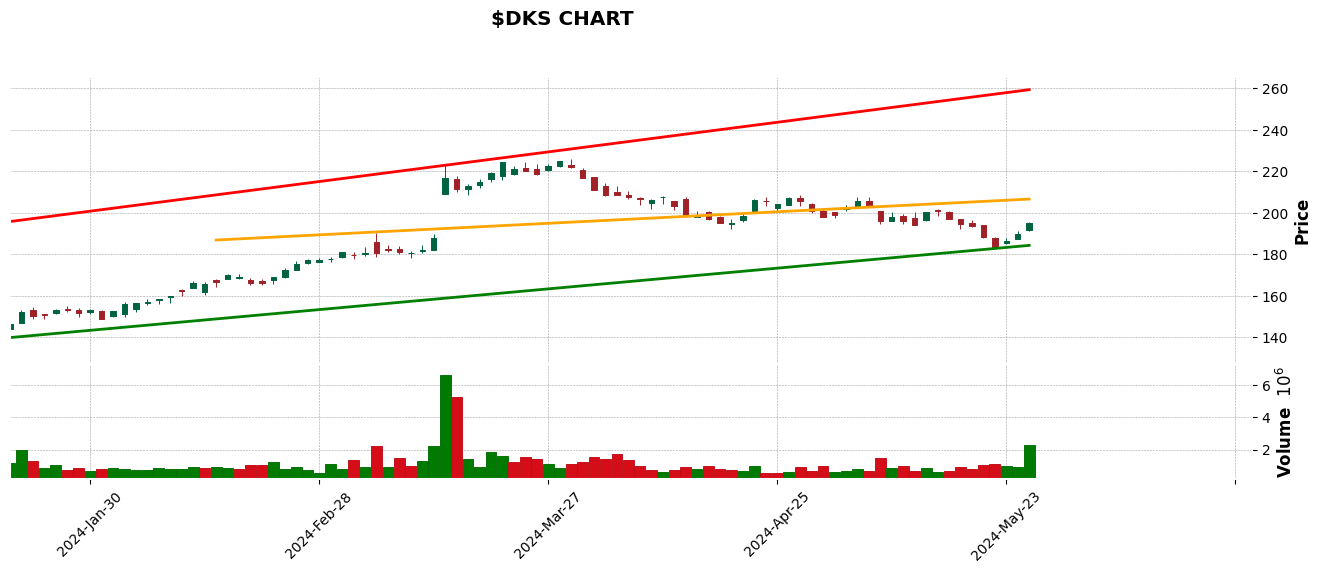

In [1199]:
#### CHART IT ####
# Define the period for the x-axis view and future extension
lookback_periods = 90
future_periods = 20

# Calculate the extended index for the lookback period
lookback_index = ticker_df.index[-lookback_periods]

# Generate the future index by adding the future periods to the last date
future_index = pd.date_range(start=ticker_df.index[-1] + pd.Timedelta(days=1),
                             periods=future_periods, freq='B')

# Combine the current and future indices
full_index = ticker_df.index.union(future_index)

# Set the xlim for plotting
xlim = (lookback_index, full_index[-1])

# Plot the candlestick chart with extended x-axis
mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'${ticker} CHART',
         figratio=(42, 14),
         xlim=xlim,  # Set the new x-axis limits
         addplot=apds)  # 'apds' should contain all your additional plots

In [1200]:
ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-14,DKS,200.49,200.570,195.925,196.48,859253
2024-05-15,DKS,201.08,201.955,198.390,201.33,604009
2024-05-16,DKS,196.92,200.900,196.840,200.23,679396
2024-05-17,DKS,194.54,197.120,192.380,196.93,890391
2024-05-20,DKS,193.73,196.680,193.390,195.25,806773
2024-05-21,DKS,188.51,194.170,187.900,193.98,1070808
2024-05-22,DKS,183.74,188.170,182.840,188.09,1108452
2024-05-23,DKS,186.60,188.040,185.080,185.44,958078
2024-05-24,DKS,189.97,191.260,187.610,187.61,894243


In [1201]:
support_line

array([133.44163027, 133.9406037 , 134.43957713, 134.93855056,
       135.437524  , 135.93649743, 136.43547086, 136.93444429,
       137.43341772, 137.93239115, 138.43136459, 138.93033802,
       139.42931145, 139.92828488, 140.42725831, 140.92623174,
       141.42520517, 141.92417861, 142.42315204, 142.92212547,
       143.4210989 , 143.92007233, 144.41904576, 144.9180192 ,
       145.41699263, 145.91596606, 146.41493949, 146.91391292,
       147.41288635, 147.91185979, 148.41083322, 148.90980665,
       149.40878008, 149.90775351, 150.40672694, 150.90570038,
       151.40467381, 151.90364724, 152.40262067, 152.9015941 ,
       153.40056753, 153.89954097, 154.3985144 , 154.89748783,
       155.39646126, 155.89543469, 156.39440812, 156.89338156,
       157.39235499, 157.89132842, 158.39030185, 158.88927528,
       159.38824871, 159.88722215, 160.38619558, 160.88516901,
       161.38414244, 161.88311587, 162.3820893 , 162.88106273,
       163.38003617, 163.8790096 , 164.37798303, 164.87

# END ADVANCED WIP TESTS

| DATA PACKAGE |
|-|
| Trend Lines |


In [1202]:
# # Step 3: Calculate the y-values for the line of best fit for the last 72 periods
# best_fit_last_72 = model.predict(X)

# # Create a series for the best fit line, filled with NaN except for the last 72 values
# best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
# best_fit_series[-72:] = best_fit_last_72

# # # Step 4: Pivot Points
# # pivot_point_low_index = last_72_df['Close'].idxmin()
# # pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

# # pivot_point_high_index = last_72_df['Close'].idxmax()
# # pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# # # Create a series for the pivot points, similar to the best fit line
# # pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_low[pivot_point_low_index] = pivot_point_low_value

# # pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_high[pivot_point_high_index] = pivot_point_high_value

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()


# # # step 5: chart setup
# # apds = [
# #     mpf.make_addplot(best_fit_series, color='orange', width=2),
# #     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
# #     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# # ]

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()

In [1203]:
# # step 5: chart setup
# apds = [
#     mpf.make_addplot(best_fit_series, color='orange', width=2),
#     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
#     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# ]

In [1204]:
# # Step X: chart it
# last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# mpf.plot(ticker_df,
#          type='candle',
#          style='charles',
#          volume=True,
#          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
#          figratio=(42, 14),
#          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
#          addplot=apds)

# mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [1205]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [1206]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [1207]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [1208]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [1209]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [1210]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [1211]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [1212]:
# chart_historical_df.head(5)

In [1213]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [1214]:
# # date column check data type
# chart_historical_df.index

In [1215]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [1216]:
# chart_historical_df.index

In [1217]:
# chart_historical_df.head(5)

In [1218]:
# print(tv_L2_df.columns)

In [1219]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [1220]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [1221]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [1222]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [1223]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [1224]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [1225]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [1226]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [1227]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [1228]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [1229]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [1230]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [1231]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [1232]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [1233]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [1234]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [1235]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [1236]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [1237]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [1238]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)